# Have reddit.com posts gotten more politically biased over the last few years?


This is a project done for a Social Sciences Data Analytics course, due June 2021. Focus is less on the complexity of the analysis and more on data mining & social insights/storytelling.

--------

The internet is known for being a place of free expression - at least, when not faced by legal and/or governmental intervention. Nonetheless, website moderation systems are not exempt of potential bias in preference for topics and postures, be it due to unconscious decisions based on moderators' proclivities, due to an underlying active agenda, due to mere coincidence, and a myriad of other possible explanations.

This is where *reddit.com*, "the frontpage of the internet", comes. Founded in June 2005, it is a USA-based "social news aggregation, web content rating, and discussion website" (quote: Wikipedia). It allows users to post free content into different topic or theme-based communities, known as *subreddits*, where there is an up-vote system that allows both rating posts themselves and comments over these posts to be ranked by users.

To illustrate the mission of Reddit, let us quote the homepage's statement:

<blockquote>Reddit is home to thousands of communities, endless conversation, and authentic human connection. Whether you're into breaking news, sports, TV fan theories, or a never-ending stream of the internet's cutest animals, there's a community on Reddit for you.</blockquote>

--------

Since each subreddit is topic or theme-based, they rely on specific sets of rules that aim to keep the spirit of the subreddit from straying. Thus, the website counts heavily on the activity of moderators - users with special permissions to remove posts, ban users from subreddits, close threads, edit certain posts, etcetera - to ensure the following of these rules by users via their granted powers (used ideally in good faith).

Over the last decade, this platform grew to be not only a gigantic social media and web content repository, but also what is considered by many one of the most active user-based webpages, and perhaps the biggest internet forum out there (at least in the Western World), considering the plethora of topics and subreddits that are being actively discussed - be it religion, politics, hobbies, fitness, memes, life advice, you name it. As of February 2021, Reddit ranked as the 18th-most-visited website in the world (source: Alexa Internet).

About one-fifth of its user base consists of 18 to 29-year-olds, almost from the USA, and around 60% from this country plus the United Kingdom and Canada. As of 2020, it had 52 million daily active users, and as of 2019, 430 million monthly users - a statistic which suggests the hefty presence of this internet platform. In 2020, 303.4 million posts were uploaded in the 2.2 million subreddits - 130,000 of which are considered active (source: businessofapps.com).




------------

In this spirit, it is an interesting question to ask oneself if such a massive platform has been able to remain as a stable platform for free expression of ideas, regardless of motivation and personal bias. In other words, we want to ask ourselves if Reddit has been able to safeguard free speech, and if it has remained free of any degree of polarization which may repel or deter potential users from expressing their opinions.

Thus, in this notebook, we want to (exploratorily) shed light to this question. We are going to explore whether this platform has gotten more politically biased during the last few years; that is, we are going to have an exploratory analysis of whether posts, in general, have gotten more left-winged, right-winged, or perhaps apolitical (which is not unfeasible considering who the main users are).


----------------

In order to test this hypothesis - emphasis in the exploratory nature of this -, we are implementing the following methodology:
* Define functions/algorithms for accessing API (explain this better)
* Customize functions for scraping posts in certain timeframes
* Define groups of subreddits that have a determined political leaning for training our model (this to be addressed later on)
    * Subreddits like r/Socialism_101, r/TheRightCantMeme, etcetera, can be considered as inherently left-wing
    * For right-wing posts, we can consider subreddits such as r/Conservative, r/Capitalism, and others mocking democrats as an example
    * We are also going to define a group of subreddits that attempt to remain particularly neutral or apolitical; this mainly concerns some hobby-based subreddits (r/Music, r/Gaming), sports, general "lifehacks" subreddits, informative subreddits, educational, etcetera
* With these groups defined, we are going to scrape posts of them from May 2021, and then some more if necessary
* Using text classification methodologies, parametric and non-parametric models are trained for predicting political leaning
* Having selected the most accurate model - in the training phase -, we are going to implement it to classify posts from popular subreddits that were not included as part of the training/validation dataset, and that might or might not be controversial (r/news, r/ChangeMyView, r/politics, r/WorldNews, etcetera)

It is worth mentioning that exclusively written posts - that is, not consisting of solely webpage links - are being used for training and testing purposes; evaluating the content of respective links might provide much more depth and accuracy into the insights, yet requires not only computational time, but also a level of complexity that escapes the purpose of an exploratory investigation such as the one we are executing in this notebook.

-----------

Let us first install and load Python packages necessary for our venture:

In [1]:
# install any packages
%pip install praw

Note: you may need to restart the kernel to use updated packages.


In [224]:
import requests
import praw
import pandas as pd
import numpy as np
import datetime
import time
import calendar
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
pd.set_option("display.max_columns",101)

## 1. Creating a training dataset

As suggested previously, we are going to create a training dataset based on subreddits with relatively explicit political inclination - be it left-wing, right-wing, or "neutral" (vide infra).

In order to obtain the dataset, we are going to combine the *requests* package - an HTTP library that allows for general implementation of API in websites - with the customized PRAW ("Pyhon Reddit API Wrapper") package - a library that is customized according to Reddit's API rules, in order to allow for intuitive usage and scraping of data in this website.

------------

For scraping, we create a user-defined API server - a requirement for the PRAW package.

We then create functions that allow for:
* Connecting to the server according to a generalized Reddit API link, request data in json format in a determined timeframe, obtain the "submissions" (posts), and append them
* Converting Unix time (the format that Reddit implements) to *datetime*
* Defining (a) specific subreddit(s), specific months of the calendar, appending posts, and converting this json array to a Pandas DataFrame

Let us create these functions below:

In [4]:
# creating a server (in this case, we connect to a user-created one)
reddit = praw.Reddit(client_id='9QL4gn3CotZfCA', client_secret='T9GUlb_QzUFYEugXndF_nWOaSgJPCA',
                     user_agent='big data project')

In [5]:
def submissions_pushshift_praw(subreddit, start=None, end=None, limit=100, extra_query=""):
    matching_praw_submissions = []
    utc_offset = 28800
    now = int(time.time())
    start = max(int(start) + utc_offset if start else 0, 0)
    end = min(int(end) if end else now, now) + utc_offset
    # Format our search link properly.
    search_link = ('https://api.pushshift.io/reddit/submission/search/'
                   '?subreddit={}&after={}&before={}&sort_type=score&sort=desc&limit={}&q={}')
    search_link = search_link.format(subreddit, start, end, limit, extra_query)
    
    # Get the data from Pushshift as JSON.
    retrieved_data = requests.get(search_link)
    returned_submissions = retrieved_data.json()['data']
    
    # Iterate over the returned submissions to convert them to PRAW submission objects.
    for submission in returned_submissions:
        
        # Take the ID, fetch the PRAW submission object, and append to our list
        praw_submission = reddit.submission(id=submission['id'])
        matching_praw_submissions.append(praw_submission)
     
    # Return all PRAW submissions that were obtained.
    return matching_praw_submissions

In [6]:
# functions for converting dates to unix format and back:
def dttounix(year, month, day, hour, minute, second):
    dt = datetime.datetime(year, month, day, hour, minute, second)
    unixtime = (dt - datetime.datetime(1970, 1, 1)).total_seconds()
    return(unixtime)

def unixtodt(unixtime):
    dt = datetime.datetime.fromtimestamp(unixtime).strftime('%Y-%m-%d %H:%M:%S')
    return(dt)

In [7]:
# used for scraping a month in particular later on
def nextfivemonth(y,m,d):
    if(d==1): return(5)
    elif(d==6): return(10)
    elif(d==11): return(15)
    elif(d==16): return(20)
    elif(d==21): return(25)
    elif(d==26): return(calendar.monthrange(y, m)[1])

In [8]:
# function for scraping a whole month of a particular subreddit:
def monthscrapesub(sub, leaning, year, month):
    df1=pd.DataFrame(columns=['created','subreddit','selftext','label'])
    # scraping in five day intervals, based on trial and error
    for d in [1, 6, 11, 16, 21, 26]:
        t_0 = dttounix(year, month, d, 0, 0, 0)
        t_f = dttounix(year, month, nextfivemonth(year, month, d), 23, 59, 59)
        sublist = submissions_pushshift_praw(subreddit=sub, start=t_0, end=t_f, limit=100, extra_query="")
        for submission in sublist:
            leaning = leaning
            if ((((submission.selftext!='[deleted]') & (submission.selftext!='[removed]')) & \
                (pd.isna(submission.selftext)==False)) & (submission.selftext!='')):
                df1=df1.append(
                    pd.Series([submission.created, submission.subreddit, submission.selftext, leaning],
                              index=df1.columns).to_frame().T,
                        ignore_index=False
                    )
    df1.created = df1.created.apply(lambda x: unixtodt(x))
    return(df1).drop_duplicates()

Having created the respective functions for scraping, we define the subreddits from which posts are being scraped, apply the functions for scraping, and label them.

For this purpose, we define the three possible classifications according to the following criteria:
* **Left:** posts from subreddits with explicit and traditionally left-winged leanings - that is, subreddits with egalitarism-based and reforming tendencies, be it centered on a determined political theory (Socialism, Critical Theory, Gramscian Marxism, etcetera), on political parties (i.e., Democratic Party of USA), or on mocking the right-winged counterparts
* **Right:** posts from subreddits with either Conservative, Capitalist, or both connotations - following an analogous criteria as of that stated for the *left*
* **None:** posts from subreddits that attempt to remain inherently informative (i.e., History), that allienate themselves from political connotations by being activity/hobby-based, and that center themselves on apolitical advice and thoughts

It is worth mentioning that executing the commands below can take from a few hours to a full day - depending on the amount of subreddits and months to scrape, and on the server status.

It is also stated that the commands below were executed iteratively, often scraping more months than stated for certain labels in order to reduce class imbalance.

In [9]:
# Defining subreddits
leftist_subr = ['communism', 'marxism', 'latestagecapitalism', 'socialism', 'socialism_101', \
               'criticaltheory','progressive', 'democrats']
right_subr = ['conservative', 'newright', 'republican', 'capitalism', 'neoliberal', \
              'whiteknighting','tories']
nolean_subr = ['history','gaming', 'todayilearned', 'showerthoughts', 'LifeProTips', \
               'DIY', 'fitness', 'sports']

In [10]:
# defining train dataframe
train_full = pd.DataFrame(columns=['created','subreddit','selftext','label'])

In [11]:
# scraping left-wing posts:
for sub in leftist_subr:
    # due to computational time, only may is scraped
    for year in [2020, 2021]:
        for month in [5]:
            try:
                train_full = train_full.append(monthscrapesub(sub, 'left', 2020, month))
            except:
                pass

In [12]:
# scraping right-wing posts:
for sub in right_subr:
    # due to computational time, only may is scraped
    for year in [2020, 2021]:
        for month in [5]:
            try:
                train_full = train_full.append(monthscrapesub(sub, 'right', 2020, month))
            except:
                pass

In [ ]:
# scraping neutral posts:
for sub in nolean_subr:
    for year in [2020,2021]:
        for month in [5]:
            try:
                train_full = train_full.append(monthscrapesub(sub, 'none', 2020, month))
            except:
                pass

In [16]:
train_full = train_full.drop_duplicates()
print(train_full['label'].value_counts())

none     1468
left     1381
right     654
Name: label, dtype: int64


In [15]:
# dimensions of the subreddits
print(train_full.shape)

(3503, 4)


In [104]:
train_full.sample(10)

,created,subreddit,selftext,label
273,5/3/2021 11:30,Socialism_101,So a tik toker says mao killed 40 million whic...,left
446,5/20/2021 6:03,Socialism_101,I am looking for a theory guide that is short ...,left
1329,2/1/2021 6:07,stevencrowder,"Hey guys,\n\nWas wondering if anyone would lik...",right
2229,5/17/2019 6:47,history,Khrushchev is most well known for his destalin...,none
408,5/13/2021 10:52,Socialism_101,I’ve always been somewhat neutral on the Israe...,left
306,5/8/2021 23:02,Socialism_101,I'm having a hard time wrapping my head around...,left
2148,5/13/2019 4:24,history,How did a person from Italia feel about workin...,none
100,5/17/2021 6:40,Marxism,Is it simply a conspiracy theory on the right ...,left
2577,5/25/2021 1:00,history,Historians are ridiculously addicted to consen...,none
2075,5/7/2019 23:20,history,"Phillip IV ordered his ""agents"" to arrest the ...",none


-------------
## 2. Defining a prediction model for political affiliation

Having labeled a dataset of posts, we now attempt to build/train a satisfactory model for predicting posts' political inclinations, with the purpose of labeling the test dataset with some level of accuracy.

We are going to attempt three models for prediction: **multinomial logistic regression**, **K-nearest neighbors*, and **random forest classifier**.

The model to be utilized on the test dataset (to be addressed later on) will be the one with the highest accuracy; in order to mitigate overfitting, we are splitting the full training dataset into train and validation sets.

In [17]:
# it's always good to back up your data
# train_full.to_csv(r'C:\Users\ncozz\Documents\--- KUL\2 Sem\Collecting Big Data\trainbigdata.csv', index = False)

In [9]:
# loading data
# train_full = pd.read_csv('C:/Users/ncozz/Documents/--- KUL/2 Sem/Collecting Big Data/trainbigdata.csv')

In [10]:
train, val = train_test_split(train_full, test_size=0.2, random_state = 777)

--------------
### 2.1. Logistic Regression
Let us first attempt training a (multinomial) logistic regression model, which regresses the logit link function of the probability of belonging to a certain category with a linear predictor - consisting, in this case, of the vectorized subreddit text multiplied by the estimated coefficients of the MLR.

We are going to vectorize the reddit texts - removing stop words -, train a LR model that predicts the political leaning ("label") based on the (vectorized) text, and calculate the accuracy on the validation set.

In [11]:
vectorizer  = CountVectorizer(lowercase  =  True,
                             stop_words  = 'english',
                             ngram_range = (1,3),
                             max_features = None)

lr_classifier = LogisticRegression(max_iter=1000)

In [12]:
vectorizer.fit(train['selftext'])
X_train = vectorizer.transform(train['selftext'])
X_val = vectorizer.transform(val['selftext'])

In [99]:
lr_classifier.fit(X_train, train['label'])

LogisticRegression(max_iter=1000)

In [100]:
print(accuracy_score(train['label'],
                     lr_classifier.predict(X_train)))

0.9985724482512491


In [101]:
val_prediction = lr_classifier.predict(X_val)

In [102]:
print(accuracy_score(val['label'], val_prediction))

0.7674750356633381


What of the performance when stemming words?

In [28]:
eng_stemmer = SnowballStemmer("english")

def stem_sentence(sentence):
    new_sentence = ''
    for word in word_tokenize(sentence):
        new_sentence = new_sentence + ' ' + eng_stemmer.stem(word)
    return new_sentence

In [29]:
train_stemtext = train['selftext'].apply(lambda x: stem_sentence(x))

In [30]:
vectorizer.fit(train_stemtext)
X_train_stem = vectorizer.transform(train_stemtext)

In [31]:
lr_classifier.fit(X_train_stem, train['label'])

LogisticRegression(max_iter=1000)

In [32]:
print(accuracy_score(train['label'],
                     lr_classifier.predict(X_train_stem)))

0.9982155603140613


In [33]:
val_stemtext = val['selftext'].apply(lambda x: stem_sentence(x))

In [34]:
X_val_stem = vectorizer.transform(val_stemtext)
val_prediction_stem = lr_classifier.predict(X_val_stem)

In [35]:
print(accuracy_score(val['label'], val_prediction_stem))

0.7503566333808844


Stemming words does not seem to inherently improve performance; hence, we shall stick to just vectorizing and removing stop words.

Next, searching for the best parameters, via 10-fold cross-validation:

In [13]:
vectorizer.fit(train['selftext'])

CountVectorizer(ngram_range=(1, 3), stop_words='english')

In [14]:
kfolds = StratifiedKFold(5)

In [22]:
parameters_lr = {'penalty' : ['l2'],
    'C' : np.logspace(-1, 1, 10),
    'solver' : ['saga'],
    'class_weight': ['balanced'],
    'multi_class': ['multinomial']}

grid_lr = GridSearchCV(LogisticRegression(), 
                    parameters_lr, 
                    cv = 5,
                    n_jobs = -1,
                   verbose = 2)

In [23]:
cv_lr = GridSearchCV(lr_classifier, param_grid = parameters_lr, cv = kfolds.split(X_train, train['label']),
                     verbose=2, n_jobs=-1)

In [24]:
best_lr = cv_lr.fit(X_train, train['label'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\ncozz\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [18]:
best_lr.best_params_

{'C': 5.994842503189409, 'penalty': 'l2', 'solver': 'saga'}

Fitting the model with the selected parameters:

In [41]:
# train accuracy:
lr_classifier = LogisticRegression(max_iter=1000, multi_class='multinomial',
                                   C=6, class_weight='balanced',
                                   penalty='l2', solver='saga')
lr_classifier.fit(X_train, train['label'])
print(accuracy_score(train['label'],
                     lr_classifier.predict(X_train)))

0.9282655246252677


C:\Users\ncozz\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [42]:
# validation accuracy:
val_prediction_lr = lr_classifier.predict(X_val)
print(accuracy_score(val['label'], val_prediction))

0.7631954350927247


----------------
### 2.2 K-nearest neighbors

This is a non-parametric model; it is based on the estimation of a label based on the text of its nearest *k* neighbors - based off Euclidean distance.

An analogous procedure as of the MLR follows:

In [259]:
kfolds = StratifiedKFold(5)
parameters = {'n_neighbors' : [3,5,7,9,11,13,15,17,19],
              'weights'      : ['distance', 'uniform']}

grid_kn = GridSearchCV(KNeighborsClassifier(), 
                    parameters, 
                    cv = kfolds.split(X_train, train['label']),
                    n_jobs = -1,
                   verbose = 2)

In [260]:
grid_kn.fit(X_train, train['label'])

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=<generator object _BaseKFold.split at 0x000002A81989AE40>,
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'weights': ['distance', 'uniform']},
             verbose=2)

In [261]:
print(grid_kn.best_params_)

{'n_neighbors': 15, 'weights': 'distance'}


In [262]:
knn_classifier = KNeighborsClassifier(n_neighbors = 15, weights = 'distance')

In [263]:
knn_classifier.fit(X_train, train['label'])

KNeighborsClassifier(n_neighbors=15, weights='distance')

In [264]:
# train accuracy:
knn_prediction = knn_classifier.predict(X_train)
print(accuracy_score(train['label'],
                     knn_prediction))

0.9989293361884368


In [265]:
# validation accuracy:
knn_val_prediction = knn_classifier.predict(X_val)
print(accuracy_score(val['label'], knn_val_prediction))

0.42082738944365194


## 2.3. Random forest classifier

This model, also non-parametric, allows for a decision tree based off averaging multiple "deep" decision trees, selecting for this purpose minimum and maximum depth/features/leaves, and attempting to reduce the entropy (measurement of "disorder") of the resulting classifier.

The script is as follows:

In [25]:
rfc = RandomForestClassifier()
rf_param_grid = {'n_estimators':[1000, 3000], "max_depth": [None],
          "max_features": [3000, 10000], "min_samples_leaf": [2], "criterion": ["entropy"]}

In [26]:
cv_rf = GridSearchCV(rfc, param_grid = rf_param_grid, cv = kfolds.split(X_train, train['label']),
                     verbose=2, n_jobs=-1)

In [27]:
best_rf = cv_rf.fit(X_train, train['label'])

Fitting 10 folds for each of 54 candidates, totalling 540 fits


In [28]:
best_rf.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 3000,
 'min_samples_leaf': 2,
 'n_estimators': 1000}

In [43]:
rfc = RandomForestClassifier(criterion= 'entropy', max_depth=None, max_features= 3000,
                             min_samples_leaf= 2, n_estimators= 1000)
rfc.fit(X_train, train['label'])

RandomForestClassifier(criterion='entropy', max_features=3000,
                       min_samples_leaf=2, n_estimators=1000)

In [44]:
# train accuracy:
print(accuracy_score(train['label'],
                     rfc.predict(X_train)))

0.9018558172733762


In [45]:
# validation accuracy:
rfc_val_prediction = rfc.predict(X_val)
print(accuracy_score(val['label'], rfc_val_prediction))

0.7303851640513552


-------

**So, which model shall we choose to implement?**

The logistic regression proves, in the current scenario, to be superior to K-nearest neighbors for predicting the label (political leaning) of the selected reddit posts - using as criteria the accuracy over the validation set.

The lackluster performance of KNN might have to do with it not only being inherently non-parametric, but based off of distances between different observation's features (words in the text), leading to potential overfitting and low adaptability when one does not possess a large enough dataset - i.e., very high diversity of text topics and styles. This is further accentuated when one considers that language is an inherent and defining trait of human expression and identity, and can lead to an infinite amount of arrangements and combinations of its signifiers.

Random forest classifier has a decent performance, since it is based off of decision paths and accounts for entropy (the level of information and uncertainty contained in the possible outcomes). Still, logistic regression shows slightly better performance, in terms of validation set accuracy (76.3% versus 73%).

---------

What of the possibility of misclassifying being higher for certain classes (*labels*)? Let us plot heatmaps for classifications of MLR and RFC applied to the validation set predictions:

<AxesSubplot:>

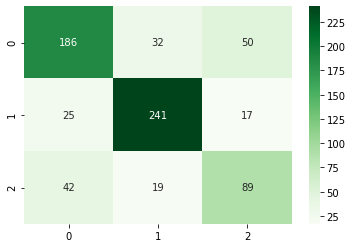

In [267]:
# Heatmap for multinomial logistic regression classifier:
cm = confusion_matrix(val['label'], val_prediction_lr)
sns.heatmap(cm, annot=True, cmap="Greens", fmt='g')

<AxesSubplot:>

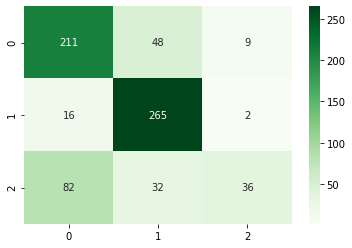

In [46]:
# Heatmap for random forest classifier:
cm2 = confusion_matrix(val['label'], rfc_val_prediction)
sns.heatmap(cm2, annot=True, cmap="Greens", fmt='g')

We can observe that the Random Forest Classifier does a relatively poor job at predicting right-winged posts; the multinomial logistic regression has much more balanced predictions.

**Thus, we stick to multinomial logistic regression for labeling the test dataset.**

------

Let us now implement this classification model, and go back to the original question.

--------------

## 3. Creating and implementing a test dataset

In this section, we are going to scrape posts from popular, politics-related, and not inherently biased (at least nominally) subreddits.
The ones selected are related directly to discussion in general, politics, economics, and news in general.

Posts are scraped for 2018, 2019, 2020 and 2021, with the purpose of evaluating a potential shift in political leaning of different subreddits over time.

In order to accomplish this, we first predict the political leaning of each of these posts, using the "best model" based on the results of the previous section.

-------

It is worth mentioning that there are strong caveats regarding the upcoming insights:
* Since both the train and test datasets are based off of arbitrary posts, whatever patterns may come out of this notebook are in no shape or form conclusive for the whole website
* There is an endless spectrum of topics which has not been considered in the train dataset - to quote Ludwig Wittgenstein, "*language is a part of our organism and no less complicated than it*" -; this might heavily contribute to misclassification of the test dataset's posts
* Also regarding misclassification, an alternative to mitigate it could have been labeling part of the test dataset's posts manually based on their content, and including them in the training phase; this, however, would not only imply a significant time investment, but would also add an undesirable level of subjectivity into any upcoming insights

---------

Back to scraping the test dataset, we define the subreddits below, and apply the previously defined algorithm for scraping:

In [98]:
test_subreddits = ['worldnews', 'news', 'economics', 'politics','worldpolitics','nostupidquestions',
                  'askreddit','offmychest','changemyview','politicaldiscussion']
test = pd.DataFrame(columns=['created','subreddit','selftext','label'])

In [100]:
# scraping posts from popular forums with discussion:
for sub in test_subreddits:
    for year in [2018, 2019, 2020]:
        for month in [5]: # due to computational time, only may is scraped
            try:
                test = test.append(monthscrapesub(sub, '', year, month))
            except:
                pass
    for month in [5]: # due to computational time, only may is scraped
        try:
            test = test.append(monthscrapesub(sub, '', 2021, month))
        except:
            pass

In [21]:
# scraping posts from popular forums with discussion:
for sub in ['changemyview','politicaldiscussion']:
    for year in [2018, 2019, 2020]:
        for month in [5]: # due to computational time, only may is scraped
            try:
                test = test.append(monthscrapesub(sub, '', year, month))
            except:
                pass
    for month in [5]: # due to computational time, only may is scraped
        try:
            test = test.append(monthscrapesub(sub, '', 2021, month))
        except:
            pass

In [114]:
test = test.drop_duplicates()
print(test.shape)

(3693, 6)


In [23]:
# again, it's always good to back up your data!
# test = test.drop_duplicates()
# test.to_csv(r'C:\Users\ncozz\Documents\--- KUL\2 Sem\Collecting Big Data\testbigdata.csv', index = False)

In [47]:
# loading data
# test = pd.read_csv('C:/Users/ncozz/Documents/--- KUL/2 Sem/Collecting Big Data/testbigdata.csv')

In [48]:
test['year'] = pd.to_datetime(test['created'])
test['year'] = test['year'].apply(lambda x: x.year)

In [103]:
test[['created','subreddit','selftext']].sample(10)

,created,subreddit,selftext
1059,5/24/2021 4:55,NoStupidQuestions,Hi! I have really bad anxiety especially in si...
2941,2018-05-30 03:21:07,changemyview,I believe that if the NFL players want to prot...
2966,2019-05-02 00:45:52,changemyview,#WARNING: SPOILERS\n\nI thought Endgame was wo...
251,5/25/2018 17:57,NoStupidQuestions,"In this hypothetical, both are creatures of si..."
1060,5/24/2021 3:17,NoStupidQuestions,Hello all! Wondering if someone could walk me ...
3177,2019-05-25 13:37:17,changemyview,The purpose of giving the executive emergency ...
253,5/22/2018 22:17,NoStupidQuestions,Assuming they were prepared in the same way
3364,2020-05-17 08:53:11,changemyview,Humanity went generations having to critically...
3673,2021-05-19 02:12:24,PoliticalDiscussion,[Val Demmings (D-FL) appears poised to challen...
3316,2020-05-15 01:07:51,changemyview,This post is about presidential elections in t...


In [104]:
print(test['subreddit'].value_counts())

offmychest             1392
NoStupidQuestions      1108
changemyview            973
PoliticalDiscussion     170
worldpolitics            19
politics                 14
Economics                 8
AskReddit                 6
news                      2
worldnews                 1
Name: subreddit, dtype: int64


### Predicting test reddit posts' political leanings

As stated beforehand, we implement the selected prediction model (multinomial logistic regression) for labeling subreddit posts, with vectorized texts and stop words removed:

In [49]:
X_test = vectorizer.transform(test['selftext'])

In [268]:
test['label_prediction'] = lr_classifier.predict(X_test)
test['label_prediction'].value_counts()

none     2226
left      909
right     558
Name: label_prediction, dtype: int64

Most predicted posts seem to have a rather "neutral" inclination, regarding political affiliation.

In [51]:
test.groupby(['year', 'label_prediction']).size().unstack(fill_value=0)

label_prediction,left,none,right
year,,,
2018,264,630,226
2019,229,629,145
2020,244,462,101
2021,172,505,86


In [269]:
test['subreddit'].value_counts()

offmychest             1392
NoStupidQuestions      1108
changemyview            973
PoliticalDiscussion     170
worldpolitics            19
politics                 14
Economics                 8
AskReddit                 6
news                      2
worldnews                 1
Name: subreddit, dtype: int64

---------------

Let us stick to the four subreddits with most observations in out test dataset.

A bit of counting for each subreddit's predicted labels:

In [52]:
largest_sr = ['PoliticalDiscussion','NoStupidQuestions','changemyview','offmychest']
largest_sr_df = test.loc[test.subreddit.isin(largest_sr)]

In [53]:
test.loc[test.subreddit==largest_sr[0]].groupby(
    ['year', 'subreddit', 'label_prediction']).size().unstack(fill_value=0)

,label_prediction,left,none,right
year,subreddit,,,
2018,PoliticalDiscussion,25,11,28
2019,PoliticalDiscussion,17,4,16
2020,PoliticalDiscussion,10,3,11
2021,PoliticalDiscussion,15,10,20


In [54]:
test.loc[test.subreddit==largest_sr[1]].groupby(
    ['year', 'subreddit', 'label_prediction']).size().unstack(fill_value=0)

,label_prediction,left,none,right
year,subreddit,,,
2018,NoStupidQuestions,47,194,31
2019,NoStupidQuestions,59,175,20
2020,NoStupidQuestions,75,164,36
2021,NoStupidQuestions,65,215,27


In [55]:
test.loc[test.subreddit==largest_sr[2]].groupby(
    ['year', 'subreddit', 'label_prediction']).size().unstack(fill_value=0)

,label_prediction,left,none,right
year,subreddit,,,
2018,changemyview,135,121,149
2019,changemyview,113,113,78
2020,changemyview,84,49,34
2021,changemyview,39,37,21


In [56]:
test.loc[test.subreddit==largest_sr[3]].groupby(
    ['year', 'subreddit', 'label_prediction']).size().unstack(fill_value=0)

,label_prediction,left,none,right
year,subreddit,,,
2018,offmychest,51,299,12
2019,offmychest,36,335,24
2020,offmychest,73,245,13
2021,offmychest,53,236,15


----------

### So, does there seem to be an actual trend in popular subreddits' political preferences?

With the predicted totals calculated above, let us plot the evolution of the share of political inclinations in these subreddit's post over the last four years:

In [235]:
grouped_test = largest_sr_df.groupby(['subreddit','label_prediction','year']).count()
grouped_total = largest_sr_df.groupby(['subreddit','year']).count()
grouped_pcts = grouped_test.div(grouped_total, axis=0).round(decimals=4)*100
grouped_pcts = grouped_pcts['selftext'].reset_index().rename(columns={'selftext': 'pctg_label'})

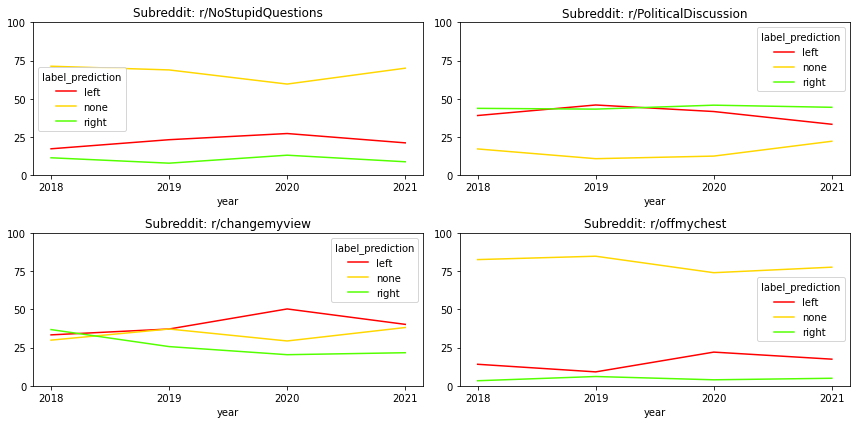

In [258]:
fig, ax = plt.subplots(2,2, figsize=(12, 6))

axi=iter(ax.flatten())

y = grouped_pcts.groupby(
    ['year','subreddit','label_prediction'])[['pctg_label']].sum().reset_index().groupby(['subreddit'])

for name, group in y :
    group.set_index(['year','label_prediction'])['pctg_label'].unstack().plot(
        title='Subreddit: r/'+name, ax=next(axi),legend=True, ylim=(0,100), colormap = 'prism')
    plt.tight_layout()
    
for axi in ax.flat:
    axi.xaxis.set_major_locator(plt.MaxNLocator(4))
    axi.yaxis.set_major_locator(plt.MaxNLocator(4))

From the above illustrations, some patterns seem to showcase:
* **r/NoStupidQuestions:** it seems to have remained mostly neutral throughout the years; some level of left-leaning postures seems to prevail over right-wing, which could be explained partly by Reddit's userbase demographics
* **r/PoliticalDiscussion:** this subreddit, being inherently politics-themed, shows rather strong political opinions, whether it be to the left or right end of the political spectrum; there are no clear patterns over which posture prevails - there seems to be a slight prevalence of right-winged posts
* **r/changemyview:** this forum seems to have become a platform for venting for left-leaning users over the years; particularly, 2020 seems to have been a heated year (we all can guess why), and these left-leaning users benefited from this internet media to express themselves
* **r/offmychest:** similar to subreddit r/NoStupidQuestions, it seems to have remained quite neutral over the years

---------------------

So... have reddit.com posts gotten more politically biased over the last few years? (Yes, I am quoting the original title)

Based off of this exploratory analysis's results, Reddit seems to have remained somewhat true to its mission over the last few years, which is to ensure that "*there's a community on Reddit for you*". Overall, the scraped posts do not seem to lean to the left or to the right vehemently enough to make of Reddit's content prevalently biased, and there does not seem to be any evident trend in potential bias to state any increasing level of (covert) activism.

The scraped posts, considering the prevalence of neutrality, seem to have a slight inclination towards the left. This might have to do with the prevalence in the userbase of Gen-Z and millennials, whose political affiliation seems to prefer the left over the right. To back up that statement, I contextualize this in the USA:

<blockquote>
    In Pew Research Center surveys conducted in 2017,[...] Millennial voters (born 1981 to 1996) have had a Democratic tilt since they first entered adulthood; this advantage has only grown as they have aged.
    
Democrats enjoy a 27-percentage-point advantage among Millennial voters (59% are Democrats or lean Democratic, 32% are Republican or lean Republican). In 2014, 53% of Millennial voters were Democrats or leaned Democratic, 37% tilted toward the GOP.
    
Millennials remain more likely than those in older generations to call themselves independents (44% vs. 39% of Gen Xers, 32% of Boomers and 27% of Silents); still, the roughly two-to-one Democratic advantage among Millennials is apparent both in “straight” and “leaned” partisan affiliation.</blockquote>

Regarding subreddits themselves, the posts seem to have been able to maintain their original levels of ideological affiliations and motivations, and their content has not evolved in any evident way to become a platform for blatant political activism. In other words, they seem to have succeeded between 2018 and 2021 to stick to their roots, and to prevent the spirit of them from straying.

-------

Considering results as nonconclusive, reddit.com seems to have been able to abstain itself from becoming more politically biased... for now.